# Interpolation of GMAT ephemeridis 
### Giacomo Menegatti, 2122852

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np


In [199]:
# \s+ works for multiple whitespaces as separators because the tab char is different on my computer
data = pd.read_table('G01_2070_2_900s_GMAT.txt', sep='\s+',header=0)
data_true = pd.read_table('G01_2070_2_60s_GMAT.txt', sep='\s+',header=0)
data.head(5)


,%,GPSTIME,X,Y,Z,VX,VY,VZ
0,2458736.5,0.000000,-1.419130e+07,4.333878e+06,2.181182e+07,-532.781897,-2764.724409,231.537398
1,2458736.5,0.010417,-1.473848e+07,1.856829e+06,2.182825e+07,-681.212656,-2730.471331,-194.895221
2,2458736.5,0.020833,-1.541258e+07,-5.645504e+05,2.146239e+07,-813.325899,-2641.549981,-616.746642
3,2458736.5,0.031250,-1.619501e+07,-2.882787e+06,2.072172e+07,-920.615369,-2502.107219,-1026.571255
4,2458736.5,0.041667,-1.705997e+07,-5.054936e+06,1.962031e+07,-995.573033,-2318.021890,-1417.229581


# Piecewise interpolation

The interpolation here is done by using a piecewise polynomial interpolation between the closest points. 

In [200]:
# The timing data are given in Julian date. The % column represents the Julian date of the day,
# while the 'GPS' time represent the time as fraction of a day

t = np.array(data['GPSTIME']) #Time from start
N = t.shape[0]-1  # Number of divisions
#The last time
t[-1] = 1.0 #The last value is 0.0 instead of 1.0 beacuse the Julian date is changed


x,y,z,vx,vy,vz = data['X'], data['Y'], data['Z'], data['VX'], data['VY'], data['VZ']
x_t,y_t,z_t,vx_t,vy_t,vz_t = data_true['X'], data_true['Y'], data_true['Z'], data_true['VX'], data_true['VY'], data_true['VZ']

f = interp1d(t, [x,y,z, vx,vy,vz])


### A plot to see the quality of the fit

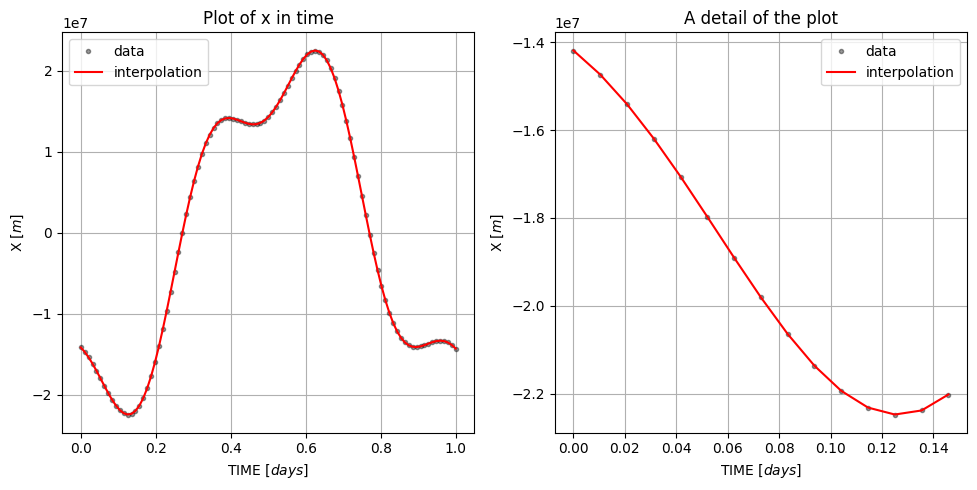

In [201]:
fig, axs = plt.subplots(1,2, figsize=[10,5])

axs[0].set_title('Plot of x in time')
axs[0].grid()
axs[0].set_xlabel('TIME [$days$]')
axs[0].set_ylabel(r'X [$m$]')
axs[0].plot(t,x, 'k.', label='data', alpha =0.4)
axs[0].plot(t, f(t)[0], 'r-', label='interpolation')
axs[0].legend()

axs[1].set_title('A detail of the plot')
n = 15
axs[1].grid()
axs[1].set_xlabel('TIME [$days$]')
axs[1].set_ylabel(r'X [$m$]')
axs[1].plot(t[0:n],x[0:n], 'k.', alpha =0.4, label='data')
axs[1].plot(t[0:n], f(t[0:n])[0], 'r-', label='interpolation')
axs[1].legend()

fig.tight_layout()


# Generation of new data
Data are taken every 1day/96 = 900 s. To have them every 60 seconds I multiply the number of points by 15 to have 1440 points

In [202]:
T = np.linspace(0, 1.0, N*15+1)

# Creating an array for the julian date and adding one to the last value
julian_date = [data['%'][0]]*T.shape[0]
julian_date[-1] = julian_date[0]+1

new_data = pd.DataFrame({'%': julian_date, 'T':T, 'X':f(T)[0], 'Y':f(T)[1], 'Z':f(T)[2], 'VX':f(T)[3], 'VY':f(T)[4], 'VZ':f(T)[5]})
new_data.to_csv('G01_2070_2_900s_GMAT_DENSE_INTERP1D.txt', sep='\t', index=False)


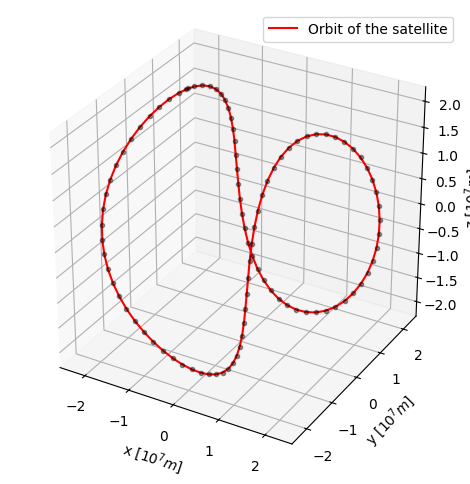

In [203]:
uom = 1e7 #Unit of measure in the plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(f(T)[0]/uom, f(T)[1]/uom, f(T)[2]/uom, 'r', label = 'Orbit of the satellite')
ax.plot(x/uom,y/uom,z/uom,'k.', alpha =0.4)
ax.set_box_aspect([1,1,1])
ax.set_xlabel(f'x [$10^7 m$]')
ax.set_ylabel(f'y [$10^7 m$]')
ax.set_zlabel(f'z [$10^7 m$]')
ax.legend()
plt.tight_layout()


## Residuals
To obtain a measure of the goodness of the interpolation I have calculate the squared residuals on the distances with respect to the fit points and the real points. As expected the interpolation gets all the points correctly and that error is extremely small, while there is a significant residual w.r.t the true points.

In [204]:
r = np.array((x_t,y_t,z_t))
res_true_pw = np.sum(np.linalg.norm(r-f(T)[0:3], axis=0)**2)

r = np.array((x,y,z))
res_pw = np.sum(np.linalg.norm(r-f(t)[0:3], axis=0)**2)

print(f'Sum of squared residuals w.r.t. the true points: {res_true_pw:.4e}')
print(f'Sum of squared residuals w.r.t. the interpolation points: {res_pw:.4e}')


Sum of squared residuals w.r.t. the true points: 1.5749e+12
Sum of squared residuals w.r.t. the interpolation points: 1.3426e-18


# Interpolation using the Chebyshev's polynomials

In [205]:
from numpy.polynomial.chebyshev import chebfit, chebval


The interpolation result depends on the degree of the Chebyshev0s polynomial used in the fit, so I calculated the residuals obtained with different degrees from 20 to 97 (the max is 97, which is the total number of points)

In [206]:

degs = np.arange(20,100,5)
res_cheb = []
res_true_cheb = []
for deg in degs:
  coef = chebfit(t, np.array([x,y,z,vx,vy,vz]).T, deg=deg)
  pred = chebval(t,coef)
  res_cheb.append(np.sum((x-pred[0])**2+(y-pred[1])**2+(z-pred[2])**2))

  pred = chebval(T,coef)
  res_true_cheb.append(np.sum((x_t-pred[0])**2+(y_t-pred[1])**2+(z_t-pred[2])**2))


/home/menegattig/.local/lib/python3.10/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


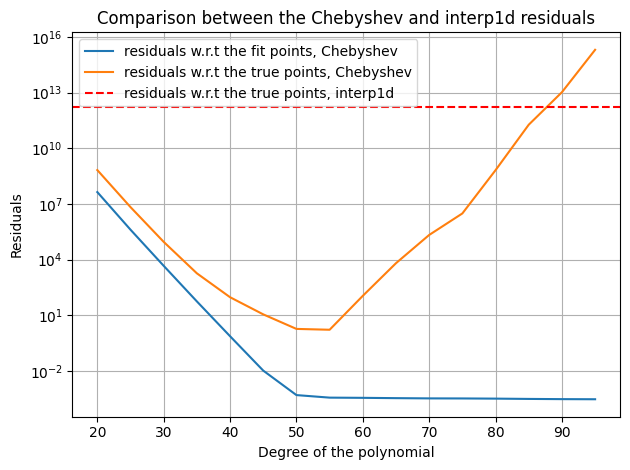

In [207]:
plt.title('Comparison between the Chebyshev and interp1d residuals')
plt.plot(degs, res_cheb, label='residuals w.r.t the fit points, Chebyshev')
plt.plot(degs, res_true_cheb, label='residuals w.r.t the true points, Chebyshev')
plt.axhline(y=res_true_pw, label='residuals w.r.t the true points, interp1d', color='red', ls='dashed')
plt.grid()
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('Degree of the polynomial')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


From the plot it appears that the fit is much better than the interpolation. The orange curve, which represents the residuals w.r.t the true points, show both an underfitting and an overfitting trend varying the degree of the polynomial, and it is nearly always smaller then the residual found by the piecewise interpolation. The optimal degree appears to be 50.

In [208]:
coef = chebfit(t, np.array([x,y,z,vx,vy,vz]).T, deg=50)
pred = chebval(T,coef)


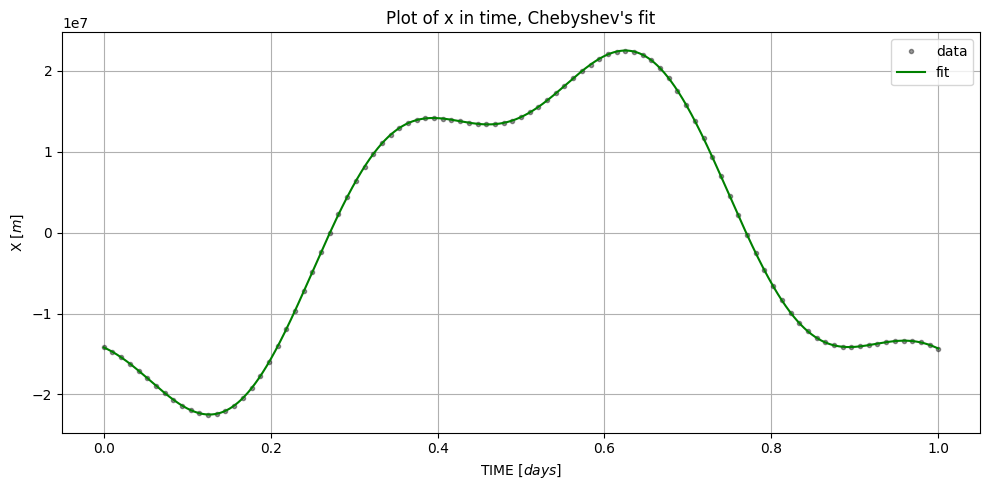

In [209]:
fig, axs = plt.subplots(1,1, figsize=[10,5])

axs.set_title("Plot of x in time, Chebyshev's fit")
axs.grid()
axs.set_xlabel('TIME [$days$]')
axs.set_ylabel(r'X [$m$]')
axs.plot(t,x, 'k.', label='data', alpha=0.4)
axs.plot(T, pred[0], 'g-', label='fit')
axs.legend()

fig.tight_layout()


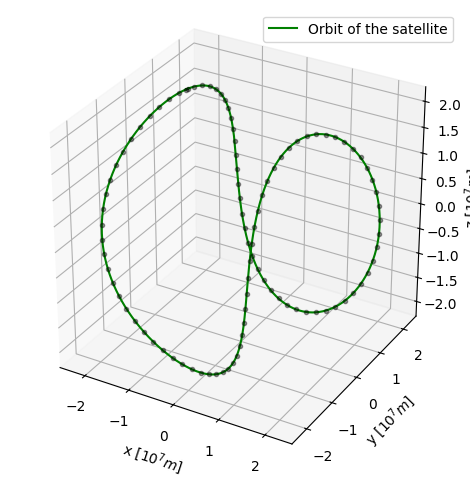

In [210]:
best = chebfit(t, np.array([x,y,z,vx,vy,vz]).T, deg=50)
pred = chebval(T,coef)

new_data = pd.DataFrame({'%': julian_date, 'T':T, 'X':pred[0], 'Y':pred[1], 'Z':pred[2], 'VX':pred[3], 'VY':pred[4], 'VZ':pred[5]})
new_data.to_csv('G01_2070_2_900s_GMAT_DENSE_CHEBYSHEV_50.txt', sep='\t', index=False)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(pred[0]/uom, pred[1]/uom, pred[2]/uom, color='g', label = 'Orbit of the satellite')
ax.plot(x/uom,y/uom,z/uom,'k.', alpha=0.4)
ax.set_box_aspect([1,1,1])
ax.set_xlabel(f'x [$10^7 m$]')
ax.set_ylabel(f'y [$10^7 m$]')
ax.set_zlabel(f'z [$10^7 m$]')
ax.legend()
plt.tight_layout()
